In [96]:
import tensorflow as tf
%matplotlib inline
import matplotlib.pyplot as plt
import pathlib
import PIL 
import numpy as np
import os
import plotly.graph_objects as go
import seaborn as sns
import os

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import image_dataset_from_directory
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

from random import sample

import warnings

warnings.filterwarnings('ignore')

In [123]:
data_dir = image_dataset_from_directory(
    '../cacao_photos/',
    label_mode='int')


Found 2829 files belonging to 3 classes.


In [124]:
class_names = data_dir.class_names

def count_data_per_class() -> None:
    for class_name in class_names:
        print(class_name, ":", len(os.listdir("../cacao_photos/"+class_name)))

def get_class_count(class_name:str) -> int:

    if class_name in class_names:
        return len(os.listdir("../cacao_photos/"+class_name))
    else:
        return 0

count_data_per_class()
get_class_count('black_pod_rot')

black_pod_rot : 943
healthy : 943
pod_borer : 943


943

In [125]:
healthy_path = "../cacao_photos/healthy"
healthy = os.listdir(healthy_path)
for file in sample(healthy,(get_class_count('healthy')-get_class_count('black_pod_rot'))):
    os.remove(healthy_path+"/"+file)

In [127]:
import Augmentor

pod_borer_augmentation_pipeline = Augmentor.Pipeline(source_directory="../cacao_photos/pod_borer",
                                                    output_directory="../cacao_photos/pod_borer/../")

pod_borer_augmentation_pipeline.rotate(probability=0.6, max_left_rotation=10, max_right_rotation=10)
pod_borer_augmentation_pipeline.skew_top_bottom(0.3, 0.7)
pod_borer_augmentation_pipeline.skew_left_right(0.3, 0.7)
pod_borer_augmentation_pipeline.flip_random(0.3)


pod_borer_augmentation_pipeline.sample(get_class_count('black_pod_rot') - get_class_count('pod_borer'))

Insufficient rights to read or write output directory (../cacao_photos/pod_borer\../cacao_photos/pod_borer/../)
Initialised with 943 image(s) found.
Output directory set to ../cacao_photos/pod_borer\../cacao_photos/pod_borer/../.

Processing <PIL.Image.Image image mode=RGB size=1080x1080 at 0x1FC56CE9300>: 100%|██████████| 943/943 [02:44<00:00,  5.73 Samples/s]                  


In [128]:
count_data_per_class()

black_pod_rot : 943
healthy : 943
pod_borer : 943


In [63]:

batch_size = 1
img_height = 224
img_width = 224
epochs = 30

In [17]:
train_dataset = image_dataset_from_directory(
    'cacao_photos/',
    validation_split = 0.2,
    labels='inferred',
    subset = 'training',
    seed=123,
    image_size=(img_height, img_width),
    batch_size= batch_size
)

Found 4390 files belonging to 3 classes.
Using 3512 files for training.


In [18]:
validation_dataset = image_dataset_from_directory(
    'cacao_photos/',
    validation_split = 0.2,
    labels='inferred',
    subset = 'validation',
    seed=123,
    image_size=(img_height, img_width),
    batch_size= batch_size
)

Found 4390 files belonging to 3 classes.
Using 878 files for validation.


In [19]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.cache().prefetch(buffer_size=AUTOTUNE)

In [20]:
normalization_layer = layers.Rescaling(1./255)

In [21]:
normalized_ds = train_dataset.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [23]:
from tensorflow.keras.applications import EfficientNetB0

In [132]:
num_classes = len(class_names)

pretrained_model = EfficientNetB0(include_top=False, input_shape=(img_height, img_width, 3))
pretrained_model.trainable = False
for layer in pretrained_model.layers:
    if not isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = True

model = Sequential([
    pretrained_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.2),
    layers.Dense(num_classes, activation="softmax")
])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  mode='min',
                                                  patience=4)

model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=[tf.metrics.SparseCategoricalAccuracy()])

model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 7, 7, 1280)       4049571   
                                                                 
 global_average_pooling2d_6   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_6 (Dropout)         (None, 1280)              0         
                                                                 
 dense_10 (Dense)            (None, 3)                 3843      
                                                                 
Total params: 4,053,414
Trainable params: 3,843
Non-trainable params: 4,049,571
_________________________________________________________________


In [133]:
from tensorflow.keras.callbacks import TensorBoard

file_name = 'kaggle_like_adam'

tensorboard = TensorBoard(log_dir="logs\\{}".format(file_name))

In [134]:
model_history = model.fit(train_dataset,
                                  epochs=epochs,
                                  callbacks = [early_stopping, tensorboard],
                                  validation_data=validation_dataset)

Epoch 1/30
703/703 [==============================] - 352s 467ms/step - loss: 0.5470 - sparse_categorical_accuracy: 0.7904 - val_loss: 0.4166 - val_sparse_categorical_accuracy: 0.8565
Epoch 2/30
703/703 [==============================] - 392s 559ms/step - loss: 0.4129 - sparse_categorical_accuracy: 0.8494 - val_loss: 0.3544 - val_sparse_categorical_accuracy: 0.8827
Epoch 3/30
703/703 [==============================] - ETA: 0s - loss: 0.3637 - sparse_categorical_accuracy: 0.8633

KeyboardInterrupt: 

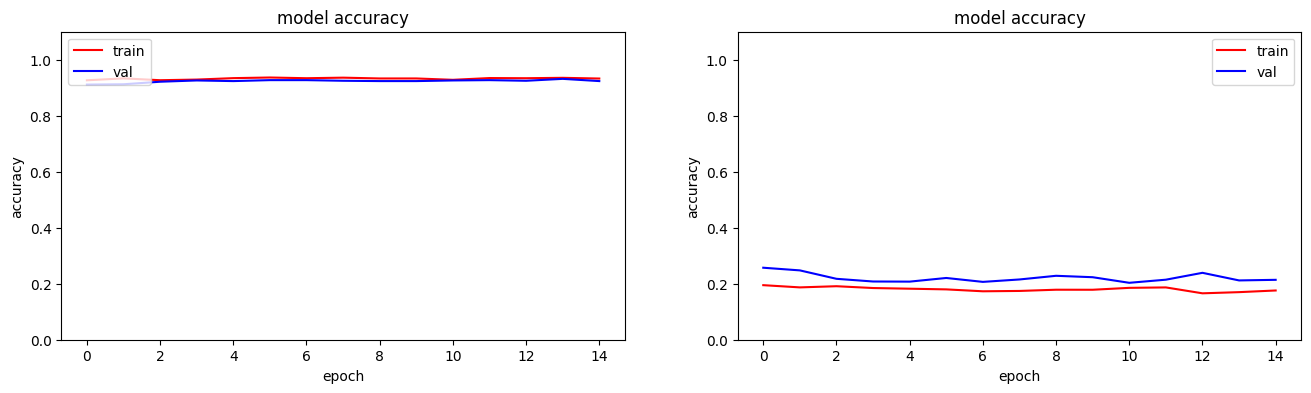

In [80]:
plt.figure(figsize=(16, 4))

plt.subplot(1, 2, 1)
plt.plot(model_history.history['accuracy'], color="red")
plt.plot(model_history.history['val_accuracy'], color="blue")
plt.title('model accuracy')
plt.ylim(top=1.1)
plt.ylim(bottom=0)
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(model_history.history['loss'], color="red")
plt.plot(model_history.history['val_loss'], color="blue")
plt.title('model accuracy')
plt.ylim(top=1.1)
plt.ylim(bottom=0)
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')

plt.show()

In [88]:

def display_training_curves(training, validation, yaxis):
    if yaxis == "loss":
        ylabel = "Loss"
        title = "Loss with respect to Epochs"
    else:
        ylabel = "Accuracy"
        title = "Accuracy with respect to Epochs"
        
    fig = go.Figure()
        
    fig.add_trace(
        go.Scatter(x=np.arange(1, epochs+1), mode='lines+markers', y=training, marker=dict(color="dodgerblue"),
               name="Training"))
    
    fig.add_trace(
        go.Scatter(x=np.arange(1, epochs+1), mode='lines+markers', y=validation, marker=dict(color="darkorange"),
               name="Validation"))
    
    fig.update_layout(title_text=title, yaxis_title=ylabel, xaxis_title="Epochs", template="plotly_white")
    fig.show()



In [89]:
display_training_curves(
    model_history.history['accuracy'], 
    model_history.history['val_accuracy'], 
    'accuracy')

In [90]:
display_training_curves(
    model_history.history['loss'], 
    model_history.history['val_loss'], 
    'validation')

In [97]:
val_pred = model_history.predict(validation_dataset)
val_cm = confusion_matrix(validation_dataset.classes,
                      np.argmax(val_pred, axis=1))
val_axis_labels = ['black pod rot', 'healthy', 'pod borer']
plt.title("Validation Set", fontsize =20)
val_ax = sns.heatmap(val_cm,
                 cmap="Red",
                 annot=True,
                 xticklabels=val_axis_labels,
                 yticklabels=val_axis_labels,
                 fmt="d")

AttributeError: 'History' object has no attribute 'predict'